In [1]:
# --- 1. SETUP AND IMPORTS ---
!pip install -U -q keras-facenet albumentations

# Standard libraries
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# ML and Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow Version:", tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 7.9 MB/s eta 0:00:00


2025-06-29 16:07:11.099822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751213231.272124      63 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751213231.325728      63 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


In [2]:
# --- 2. CONFIGURATION AND CONSTANTS ---

# Data Paths
TASK_A_PATH = "/kaggle/input/private-dataset-by-me/Comys_Hackathon5/Task_A/"
TASK_B_PATH = "/kaggle/input/private-dataset-by-me/Comys_Hackathon5/Task_B/train/"

# Model & Image Parameters
IMG_SIZE = 160
BATCH_SIZE = 32

EPOCHS_HEAD_ONLY = 15
HEAD_LR = 1e-3

# 2. Fine-tuning: More epochs for gentle adaptation with a very low learning rate.
EPOCHS_FINE_TUNE = 20
FINETUNE_LR = 2e-6
# Unfreezing later in the model is a safer fine-tuning strategy.
FINE_TUNE_FROM_LAYER = 'Block8_6_Concatenate'

# Siamese Network Parameters
EMBEDDING_DIM = 512
CONTRASTIVE_MARGIN = 1.0

In [3]:
# --- 3. DATA LOADING AND PRE-PROCESSING ---

# Initialize face detector
face_detector = MTCNN()

# Improved preprocessing function to handle difficult images more robustly.
def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Loads an image, pre-resizes for robust detection, detects the face with padding,
    and falls back to a center crop if detection fails.
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image {image_path}")
            return None
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = img_rgb.shape
        
        # --- Pre-resize for robust detection on very large images ---
        # If the image is very large, resize it before detection to improve speed and accuracy.
        max_dim = 1024
        if max(img_h, img_w) > max_dim:
            scale = max_dim / max(img_h, img_w)
            img_detect = cv2.resize(img_rgb, (int(img_w * scale), int(img_h * scale)))
        else:
            img_detect = img_rgb
            scale = 1.0

        results = face_detector.detect_faces(img_detect)
        
        face = None
        if results:
            # Find the largest face
            best_face_info = max(results, key=lambda r: r['box'][2] * r['box'][3])
            
            # --- Add padding and perform safe cropping ---
            # Rescale box coordinates back to the original image size
            x1, y1, width, height = [int(v / scale) for v in best_face_info['box']]

            # Add padding to capture more context (e.g., 20% on each side)
            pad_w = int(width * 0.2)
            pad_h = int(height * 0.2)
            
            # Calculate new padded coordinates
            x1_pad, y1_pad = x1 - pad_w, y1 - pad_h
            x2_pad, y2_pad = x1 + width + pad_w, y1 + height + pad_h
            
            # Clip coordinates to be within image boundaries (SAFE CROP)
            x1_c, y1_c = max(0, x1_pad), max(0, y1_pad)
            x2_c, y2_c = min(img_w, x2_pad), min(img_h, y2_pad)

            if x1_c < x2_c and y1_c < y2_c:
                 face = img_rgb[y1_c:y2_c, x1_c:x2_c]
        
        # --- Fallback: Center Crop if detection failed ---
        if face is None or face.size == 0:
            h, w, _ = img_rgb.shape
            crop_size = int(min(h, w) * 0.8)
            start_h = (h - crop_size) // 2
            start_w = (w - crop_size) // 2
            face = img_rgb[start_h:start_h+crop_size, start_w:start_w+crop_size]

        if face.size == 0:
            print(f"Warning: Could not extract a valid face from {image_path}")
            return None
            
        face_resized = cv2.resize(face, target_size)
        return face_resized.astype('float32') / 255.0
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

print("Scanning directories to build dataset...")
all_files = []
gender_map = {}
print("Processing Task A for gender labels...")
task_a_files_processed_for_gender = 0
task_a_files_skipped = 0
for split_folder_name in ['train', 'val']:
    split_path = os.path.join(TASK_A_PATH, split_folder_name)
    if not os.path.isdir(split_path): continue
    for gender_folder_name in ['male', 'female']:
        gender_specific_path = os.path.join(split_path, gender_folder_name)
        if not os.path.isdir(gender_specific_path): continue
        current_gender_label = 1 if gender_folder_name == 'female' else 0
        for filename in os.listdir(gender_specific_path):
            if filename.startswith('.'): continue
            name_part, ext_part = os.path.splitext(filename)
            if not ext_part.lower() in ['.jpg', '.jpeg', '.png'] or not name_part: continue
            parts = name_part.split('_')
            person_id_from_task_a = '_'.join(parts[:-1]) if len(parts) > 1 and parts[-1].isdigit() and len(parts[-1]) == 4 else name_part
            if not person_id_from_task_a: continue
            if person_id_from_task_a not in gender_map:
                gender_map[person_id_from_task_a] = current_gender_label
            task_a_files_processed_for_gender +=1

print(f"Finished processing Task A: {len(gender_map)} unique person_ids mapped.")
print(f"Example entries from gender_map: {list(gender_map.items())[:5]}")

print("\nScanning Task B for image paths...")
for person_id_folder_name in tqdm(os.listdir(TASK_B_PATH)):
    person_dir = os.path.join(TASK_B_PATH, person_id_folder_name)
    if not os.path.isdir(person_dir): continue
    gender_label = gender_map.get(person_id_folder_name, -1)
    for fname in os.listdir(person_dir):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            all_files.append({'path': os.path.join(person_dir, fname), 'person_id': person_id_folder_name, 'gender': gender_label})
    distortion_dir = os.path.join(person_dir, 'distortion')
    if os.path.exists(distortion_dir) and os.path.isdir(distortion_dir):
        for dist_fname in os.listdir(distortion_dir):
             if dist_fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                all_files.append({'path': os.path.join(distortion_dir, dist_fname), 'person_id': person_id_folder_name, 'gender': gender_label})

dataset_df = pd.DataFrame(all_files)
print(f"\nCollected {len(dataset_df)} image paths initially from Task B.")
original_len = len(dataset_df)
dataset_df = dataset_df[dataset_df['gender'] != -1].copy()
print(f"Removed {original_len - len(dataset_df)} entries from Task B due to missing gender mapping.")
print(f"Found {len(dataset_df)} total images with valid gender labels.")
if len(dataset_df) > 0:
    print(dataset_df.head())
    print("\nGender distribution (0=male, 1=female):")
    print(dataset_df['gender'].value_counts(normalize=True))
else:
    print("No images found.")

I0000 00:00:1751213243.957276      63 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Scanning directories to build dataset...
Processing Task A for gender labels...
Finished processing Task A: 1127 unique person_ids mapped.
Example entries from gender_map: [('Peter_Bacanovic', 0), ('Colin_Powell', 0), ('Bulent_Ecevit', 0), ('Michael_McNeely', 0), ('Milo_Maestrecampo', 0)]

Scanning Task B for image paths...


  0%|          | 0/877 [00:00<?, ?it/s]


Collected 15408 image paths initially from Task B.
Removed 0 entries from Task B due to missing gender mapping.
Found 15408 total images with valid gender labels.
                                                path      person_id  gender
0  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0
1  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0
2  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0
3  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0
4  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0

Gender distribution (0=male, 1=female):
gender
0    0.842679
1    0.157321
Name: proportion, dtype: float64


In [4]:
# --- 4. TRAIN / VALIDATION SPLIT ---

unique_person_ids = dataset_df['person_id'].unique()
train_ids, val_ids = train_test_split(unique_person_ids, test_size=0.2, random_state=42)

train_df = dataset_df[dataset_df['person_id'].isin(train_ids)]
val_df = dataset_df[dataset_df['person_id'].isin(val_ids)]

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 12552
Validation samples: 2856


In [5]:
# --- 4.1. CALCULATE CLASS WEIGHTS FOR IMBALANCED GENDER DATA ---
# This is a crucial step to combat overfitting on the majority class (male).
# It penalizes the model more for misclassifying the minority class (female),
# forcing it to learn more robust features instead of just guessing "male".

y_train_gender = train_df['gender'].values
class_weights_gender_list = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_gender),
    y=y_train_gender
)
gender_class_weights = dict(enumerate(class_weights_gender_list))

print(f"\nCalculated Gender Class Weights: {gender_class_weights}")
print("These will be used to penalize misclassifications of the minority class (female) more heavily.")


Calculated Gender Class Weights: {0: 0.5876404494382023, 1: 3.3525641025641026}
These will be used to penalize misclassifications of the minority class (female) more heavily.


In [6]:
# --- 4.5. INTELLIGENT PRE-PROCESSING AND CACHING ---
# IMPORTANT NOTE: The first run of this cell will be very slow (~1-2 hours) because
# it processes and saves a cropped version of every face.
# BEST PRACTICE: For much faster iteration, run this caching process once in a
# separate notebook, save the output "/kaggle/working/cached_faces/" as a new
# Kaggle Dataset, and then add that new dataset as an input to this notebook.
# You can then comment out this entire cell and load image paths directly
# from your pre-processed dataset, starting your training in seconds, not hours.

# Subsequent runs of this cell in the *same session* will be fast because it
# checks if a face is already cached.

# Set to True to delete and re-process all images.
FORCE_RECACHE = False 
# Set to True to re-process only the training images.
REPROCESS_TRAIN_SET_ONLY = False 

CACHE_DIR = "/kaggle/working/cached_faces/"

if FORCE_RECACHE and os.path.exists(CACHE_DIR):
    print("FORCE_RECACHE is True. Deleting old cache directory...")
    shutil.rmtree(CACHE_DIR)

os.makedirs(CACHE_DIR, exist_ok=True)
print(f"Cache directory is at: {CACHE_DIR}")

# --- Generate cached paths first to know what to delete ---
# This part is lightweight and just constructs the expected filenames
dataset_df['cached_path'] = dataset_df.apply(
    lambda row: os.path.join(CACHE_DIR, f"{row['person_id']}_{os.path.splitext(os.path.basename(row['path']))[0]}.png".replace(" ", "_")),
    axis=1
)

# --- Selective Deletion Logic ---
if REPROCESS_TRAIN_SET_ONLY:
    print("\nREPROCESS_TRAIN_SET_ONLY is True. Deleting cached training images...")
    # Get the list of cached paths for the training set
    train_cached_paths = dataset_df[dataset_df['person_id'].isin(train_ids)]['cached_path'].tolist()
    
    deleted_count = 0
    for path in tqdm(train_cached_paths, desc="Deleting train cache"):
        if os.path.exists(path):
            os.remove(path)
            deleted_count += 1
    print(f"Deleted {deleted_count} cached training images. They will be re-processed.")


print(f"\nStarting intelligent caching for {len(dataset_df)} images...")

records = dataset_df.to_dict('records')

newly_processed_count = 0
skipped_count = 0
failed_count = 0

for i in tqdm(range(len(records)), desc="Checking cache & processing"):
    record = records[i]
    image_path = record['path']
    cached_image_path = record['cached_path'] # Use the pre-generated path

    if os.path.exists(cached_image_path):
        skipped_count += 1
        continue # Skip to the next image
    
    # If file doesn't exist, process it
    face_array = preprocess_image(image_path)
    
    if face_array is not None:
        face_to_save = (face_array * 255).astype(np.uint8)
        cv2.imwrite(cached_image_path, cv2.cvtColor(face_to_save, cv2.COLOR_RGB2BGR))
        records[i]['cached_path'] = cached_image_path
        newly_processed_count += 1
    else:
        records[i]['cached_path'] = None # Mark as failed
        failed_count += 1

dataset_df = pd.DataFrame(records)

print("\n--- Caching Report ---")
print(f"Skipped (already cached): {skipped_count} images.")
print(f"Newly processed and saved: {newly_processed_count} images.")
print(f"Failed to process: {failed_count} images.")

original_len = len(dataset_df)
dataset_df.dropna(subset=['cached_path'], inplace=True)
print(f"\nRemoved {original_len - len(dataset_df)} failed entries. Final dataset size: {len(dataset_df)}")

# Re-create the train/val splits with the final, clean, and cached dataframe
train_df = dataset_df[dataset_df['person_id'].isin(train_ids)]
val_df = dataset_df[dataset_df['person_id'].isin(val_ids)]

print(f"\nRe-split dataframes based on successful cache:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
if not dataset_df.empty:
    print("\nDataFrame head with 'cached_path' column:")
    print(dataset_df.head())

Cache directory is at: /kaggle/working/cached_faces/

Starting intelligent caching for 15408 images...


Checking cache & processing:   0%|          | 0/15408 [00:00<?, ?it/s]


--- Caching Report ---
Skipped (already cached): 0 images.
Newly processed and saved: 15408 images.
Failed to process: 0 images.

Removed 0 failed entries. Final dataset size: 15408

Re-split dataframes based on successful cache:
Training samples: 12552
Validation samples: 2856

DataFrame head with 'cached_path' column:
                                                path      person_id  gender  \
0  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0   
1  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0   
2  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0   
3  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0   
4  /kaggle/input/private-dataset-by-me/Comys_Hack...  Ralph_Sampson       0   

                                         cached_path  
0  /kaggle/working/cached_faces/Ralph_Sampson_Ral...  
1  /kaggle/working/cached_faces/Ralph_Sampson_Ral...  
2  /kaggle/working/cached_faces/Ralph

In [7]:
# --- 5. CUSTOM DATA GENERATOR (FAST VERSION + AUGMENTATIONS) ---
import albumentations as A


transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.OneOf([
        A.MotionBlur(blur_limit=5, p=1.0),
        A.GaussianBlur(blur_limit=5, p=1.0),
    ], p=0.5),
    A.GaussNoise(p=0.3), # Use default variance to avoid parameter warnings
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=4, fill_value=0, p=0.3),
])


def load_cached_image(path):
    img = cv2.imread(path)
    if img is None: return None
    # The generator expects RGB, so we convert BGR (from cv2) to RGB
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32') / 255.0

class SiameseDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size, img_size=IMG_SIZE, shuffle=True, augment=False):
        self.df = dataframe.copy().reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment # Control augmentation
        self.person_ids = self.df['person_id'].unique()
        self.image_paths_dict = {pid: self.df[self.df['person_id'] == pid] for pid in self.person_ids}
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_img_a, batch_img_b = [], []
        batch_labels_dist, batch_labels_gender_a, batch_labels_gender_b = [], [], []

        for i in batch_indices:
            try:
                if np.random.rand() > 0.5: # Positive Pair
                    label_dist = 1.0
                    person_id = self.df.loc[i, 'person_id']
                    person_subset = self.image_paths_dict[person_id]
                    
                    # Ensure there are at least 2 images to sample from
                    if len(person_subset) < 2: continue
                    pair = person_subset.sample(n=2, replace=False) # No replacement for positive pairs
                    path_a, gender_a = pair.iloc[0]['cached_path'], float(pair.iloc[0]['gender'])
                    path_b, gender_b = pair.iloc[1]['cached_path'], float(pair.iloc[1]['gender'])
                else: # Negative Pair
                    label_dist = 0.0
                    pid1, pid2 = np.random.choice(self.person_ids, size=2, replace=False)
                    info_a = self.image_paths_dict[pid1].sample(1).iloc[0]
                    info_b = self.image_paths_dict[pid2].sample(1).iloc[0]
                    path_a, gender_a = info_a['cached_path'], float(info_a['gender'])
                    path_b, gender_b = info_b['cached_path'], float(info_b['gender'])

                img_a = load_cached_image(path_a)
                img_b = load_cached_image(path_b)

                if img_a is not None and img_b is not None:
                    if self.augment:
                        img_a = transform(image=img_a)['image']
                        img_b = transform(image=img_b)['image']

                    batch_img_a.append(img_a); batch_img_b.append(img_b)
                    batch_labels_dist.append(label_dist)
                    batch_labels_gender_a.append(gender_a)
                    batch_labels_gender_b.append(gender_b)
            except Exception as e:
                # Skip pair if any error occurs (e.g., file not found, sampling error)
                # print(f"Skipping pair due to error: {e}")
                continue
        
        # If the batch is smaller than batch_size (due to errors or last batch)
        # It's better to return a smaller batch than to pad with dummy/duplicate data
        if not batch_img_a:
             # If the batch is completely empty, return a zero batch to avoid errors
            dummy_img = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
            dummy_label = np.zeros((self.batch_size, 1), dtype=np.float32)
            return (dummy_img, dummy_img), {'distance_output': dummy_label, 'gender_output_A': dummy_label, 'gender_output_B': dummy_label}


        inputs_tuple = (np.array(batch_img_a), np.array(batch_img_b))
        outputs_dict = {
            'distance_output': np.array(batch_labels_dist).reshape(-1, 1),
            'gender_output_A': np.array(batch_labels_gender_a).reshape(-1, 1),
            'gender_output_B': np.array(batch_labels_gender_b).reshape(-1, 1)
        }
        return inputs_tuple, outputs_dict

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

print("SiameseDataGenerator with data augmentation is defined.")

SiameseDataGenerator with data augmentation is defined.


/tmp/ipykernel_63/1435770980.py:13: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=4, fill_value=0, p=0.3),


In [8]:
# --- 6. BUILDING THE SIAMESE MODEL ARCHITECTURE ---

def create_siamese_model(img_size=IMG_SIZE):
    facenet_loader = FaceNet()
    facenet_keras_model = facenet_loader.model
    facenet_keras_model.trainable = False 
    
    input_a = Input(shape=(img_size, img_size, 3), name='input_image_A')
    input_b = Input(shape=(img_size, img_size, 3), name='input_image_B')
    
    features_a = facenet_keras_model(input_a)
    features_b = facenet_keras_model(input_b)
    
    # --- Define Task-Specific Heads ---
    # 1. Verification Head (calculates distance)
    distance = Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True)),
                      name='distance_output')([features_a, features_b])

    # 2. Gender Head (shared weights) with stronger regularization
    # Increased Dropout to 0.6 and added a small L2 kernel regularizer to prevent overfitting.
    dropout_layer = Dropout(0.6) 
    gender_head_dense_layer = Dense(1, activation='sigmoid', name='gender_dense_layer',
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    
    gender_a = gender_head_dense_layer(dropout_layer(features_a))
    gender_b = gender_head_dense_layer(dropout_layer(features_b))
    
    gender_a = Lambda(lambda x: x, name='gender_output_A')(gender_a)
    gender_b = Lambda(lambda x: x, name='gender_output_B')(gender_b)
    
    siamese_model = Model(inputs=[input_a, input_b], outputs=[distance, gender_a, gender_b])
    
    return siamese_model, facenet_keras_model

model, facenet_backbone = create_siamese_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image_A             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_image_B             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_resnet_v1       │ (None, 512)            │     23,497,424 │ input_image_A[0][0],   │
│ (Functional)              │                        │                │ input_image_B[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ inception_resnet_v1[0… │
│                           │                        │                │ inception_resnet_v1[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_dense_layer        │ (None, 1)              │            513 │ dropout[0][0],         │
│ (Dense)                   │                        │                │ dropout[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distance_output (Lambda)  │ (None, 1)              │              0 │ inception_resnet_v1[0… │
│                           │                        │                │ inception_resnet_v1[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output_A (Lambda)  │ (None, 1)              │              0 │ gender_dense_layer[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output_B (Lambda)  │ (None, 1)              │              0 │ gender_dense_layer[1]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,497,937 (89.64 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 23,497,424 (89.64 MB)

In [9]:
# --- 7. LOSS FUNCTIONS AND MODEL COMPILATION ---

def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(CONTRASTIVE_MARGIN - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# Created a factory for a weighted binary cross-entropy loss function.
# This allows us to pass the class weights calculated earlier to the loss,
# which helps the model handle the imbalanced gender dataset correctly.
def create_weighted_bce(class_weights):
    def weighted_bce(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        weights = y_true * class_weights[1] + (1.0 - y_true) * class_weights[0]
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weighted_bce_loss = bce * weights
        
        return tf.reduce_mean(weighted_bce_loss)
    return weighted_bce

# Instantiate the weighted loss function for gender
weighted_bce_loss_fn = create_weighted_bce(gender_class_weights)


# Compile the model for the first stage: HEAD-ONLY training.
# We use a standard learning rate and balance the loss weights to ensure
# the new heads learn properly before fine-tuning the backbone.
model.compile(optimizer=Adam(learning_rate=HEAD_LR), 
              loss={
                  'distance_output': contrastive_loss,
                  'gender_output_A': weighted_bce_loss_fn,
                  'gender_output_B': weighted_bce_loss_fn
              },
              loss_weights={
                  'distance_output': 0.5,  # Balanced weights for both tasks
                  'gender_output_A': 1.0,  # Give gender task a strong signal
                  'gender_output_B': 1.0
              },
              metrics={
                  'gender_output_A': ['accuracy'],
                  'gender_output_B': ['accuracy']
              }
             )

print("Model compiled successfully for head-only training.")

Model compiled successfully for head-only training.


In [10]:
# --- 7.5. CALLBACKS FOR SMARTER TRAINING ---
from tensorflow.keras.callbacks import EarlyStopping

# This callback will stop training when the validation loss hasn't improved for 3 epochs.
# It will also restore the model weights from the epoch with the best validation loss.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [11]:
# --- 8. MODEL TRAINING (HEADS ONLY) ---

print("--- Training HEADS only ---")

if not train_df.empty and not val_df.empty:
    # Enable augmentations for the training generator and disable for validation
    train_generator_instance = SiameseDataGenerator(train_df, BATCH_SIZE, img_size=IMG_SIZE, augment=True)
    val_generator_instance = SiameseDataGenerator(val_df, BATCH_SIZE, img_size=IMG_SIZE, shuffle=False, augment=False)
    
    if len(train_generator_instance) > 0 and len(val_generator_instance) > 0:
        print(f"Training with {len(train_generator_instance)} steps per epoch.")
        print(f"Validating with {len(val_generator_instance)} steps per epoch.")

        history_head = model.fit(
            train_generator_instance,
            validation_data=val_generator_instance,
            epochs=EPOCHS_HEAD_ONLY,
            verbose=1,
            callbacks=[early_stopping] # Use the early stopping callback defined earlier
        )
        print("Head training complete.")
    else:
        print("Error: Data generators are empty.")
else:
    print("Error: train_df or val_df is empty. Cannot proceed with training.")

--- Training HEADS only ---
Training with 392 steps per epoch.
Validating with 89 steps per epoch.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1751216041.548147     111 service.cc:148] XLA service 0x3fd2c850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751216041.548856     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751216046.643316     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/392 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - distance_output_loss: 0.7286 - gender_output_A_accuracy: 0.3984 - gender_output_A_loss: 0.6761 - gender_output_B_accuracy: 0.3672 - gender_output_B_loss: 0.6293 - loss: 1.6699   

I0000 00:00:1751216053.369874     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


392/392 ━━━━━━━━━━━━━━━━━━━━ 123s 215ms/step - distance_output_loss: 0.6621 - gender_output_A_accuracy: 0.7747 - gender_output_A_loss: 0.6223 - gender_output_B_accuracy: 0.7688 - gender_output_B_loss: 0.6219 - loss: 1.5757 - val_distance_output_loss: 0.5120 - val_gender_output_A_accuracy: 0.8761 - val_gender_output_A_loss: 0.5217 - val_gender_output_B_accuracy: 0.8775 - val_gender_output_B_loss: 0.5242 - val_loss: 1.3032
Epoch 2/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 72s 183ms/step - distance_output_loss: 0.6470 - gender_output_A_accuracy: 0.8638 - gender_output_A_loss: 0.4543 - gender_output_B_accuracy: 0.8691 - gender_output_B_loss: 0.4413 - loss: 1.2207 - val_distance_output_loss: 0.5399 - val_gender_output_A_accuracy: 0.8708 - val_gender_output_A_loss: 0.4666 - val_gender_output_B_accuracy: 0.8701 - val_gender_output_B_loss: 0.4649 - val_loss: 1.2040
Epoch 3/15
392/392 ━━━━━━━━━━━━━━━━━━━━ 71s 181ms/step - distance_output_loss: 0.6358 - gender_output_A_accuracy: 0.8745 - gender_output_A_l

In [12]:
# --- 9. MODEL TRAINING (FINE-TUNING) ---

print("\n--- Starting Full Model Fine-Tuning ---")

# --- 1. Unfreeze Layers ---
facenet_backbone.trainable = True
fine_tune_at_index = -1
for i, layer in enumerate(facenet_backbone.layers):
    if layer.name == FINE_TUNE_FROM_LAYER:
        fine_tune_at_index = i
        break
        
if fine_tune_at_index != -1:
    print(f"Unfreezing layers from '{FINE_TUNE_FROM_LAYER}' (index {fine_tune_at_index}) onwards.")
    for layer in facenet_backbone.layers[:fine_tune_at_index]:
        layer.trainable = False
else:
    print(f"Warning: Could not find layer '{FINE_TUNE_FROM_LAYER}'. Unfreezing all trainable layers.")

# --- 2. Define Callbacks for Fine-Tuning ---
# Stop training if validation loss doesn't improve for 5 epochs
early_stopping_ft = EarlyStopping(
    monitor='val_loss',
    patience=5, # Increased patience for fine-tuning
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='min',
    min_lr=1e-8
)

# --- 3. Compile Model for Fine-Tuning with Advanced Optimizer/Scheduler ---
# We use a very low learning rate to avoid destroying the pre-trained weights.
# AdamW is often better for fine-tuning, and CosineDecay provides a smoother
# learning rate schedule than ReduceLROnPlateau.

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay

# Calculate the total number of steps for the cosine decay schedule
# This assumes you might run for the full number of epochs
decay_steps = EPOCHS_FINE_TUNE * len(train_generator_instance)
cosine_schedule = CosineDecay(initial_learning_rate=FINETUNE_LR, decay_steps=decay_steps, alpha=0.1) # Decays to 10% of LR

model.compile(
    optimizer=AdamW(learning_rate=cosine_schedule, weight_decay=1e-5), # Use AdamW with a small weight decay
    loss={
        'distance_output': contrastive_loss,
        'gender_output_A': weighted_bce_loss_fn,
        'gender_output_B': weighted_bce_loss_fn
    },
    loss_weights={
        'distance_output': 0.5,
        'gender_output_A': 1.0,
        'gender_output_B': 1.0
    },
    metrics={'gender_output_A': ['accuracy'], 'gender_output_B': ['accuracy']}
)
model.summary()

# --- 4. Fit the Model ---
print("\nFitting the fine-tuned model...")
history_fine_tune = model.fit(
    train_generator_instance, # Re-use the generator from the head training step
    validation_data=val_generator_instance,
    epochs=EPOCHS_FINE_TUNE,
    verbose=1,
    callbacks=[early_stopping_ft] #commented this out for now cuz now I am trying (hopefully) the cosine decay thingy i found on web| [reduce_lr_on_plateau]
)

print("\n--- Fine-tuning complete. ---")


--- Starting Full Model Fine-Tuning ---
Unfreezing layers from 'Block8_6_Concatenate' (index 439) onwards.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image_A             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_image_B             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_resnet_v1       │ (None, 512)            │     23,497,424 │ input_image_A[0][0],   │
│ (Functional)              │                        │                │ input_image_B[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ inception_resnet_v1[0… │
│                           │                        │                │ inception_resnet_v1[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_dense_layer        │ (None, 1)              │            513 │ dropout[0][0],         │
│ (Dense)                   │                        │                │ dropout[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distance_output (Lambda)  │ (None, 1)              │              0 │ inception_resnet_v1[0… │
│                           │                        │                │ inception_resnet_v1[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output_A (Lambda)  │ (None, 1)              │              0 │ gender_dense_layer[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output_B (Lambda)  │ (None, 1)              │              0 │ gender_dense_layer[1]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,497,937 (89.64 MB)

 Trainable params: 1,608,449 (6.14 MB)

 Non-trainable params: 21,889,488 (83.50 MB)


Fitting the fine-tuned model...
Epoch 1/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 122s 212ms/step - distance_output_loss: 0.7392 - gender_output_A_accuracy: 0.8505 - gender_output_A_loss: 0.3789 - gender_output_B_accuracy: 0.8388 - gender_output_B_loss: 0.4056 - loss: 1.1630 - val_distance_output_loss: 0.5621 - val_gender_output_A_accuracy: 0.8947 - val_gender_output_A_loss: 0.3919 - val_gender_output_B_accuracy: 0.8799 - val_gender_output_B_loss: 0.4014 - val_loss: 1.0832
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 70s 180ms/step - distance_output_loss: 0.7823 - gender_output_A_accuracy: 0.8616 - gender_output_A_loss: 0.3872 - gender_output_B_accuracy: 0.8718 - gender_output_B_loss: 0.3740 - loss: 1.1611 - val_distance_output_loss: 0.5881 - val_gender_output_A_accuracy: 0.8838 - val_gender_output_A_loss: 0.4031 - val_gender_output_B_accuracy: 0.8901 - val_gender_output_B_loss: 0.3799 - val_loss: 1.0858
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 70s 178ms/step - distance_output_loss: 0.7514 - gender_o

In [13]:
# --- 9.5. STAGE 2 FINE-TUNING (DEEPER UNFREEZING) ---

print("\n--- Starting Stage 2: Deeper Fine-Tuning ---")

# 1. Define an earlier layer to unfreeze from and an even smaller LR
DEEPER_FINE_TUNE_FROM_LAYER = 'Block8_1_Scale' # Unfreeze the entire Block8
DEEPER_FINETUNE_LR = 5e-7

# 2. Unfreeze more layers of the backbone
facenet_backbone.trainable = True
unfreeze_point_found = False
for layer in facenet_backbone.layers:
    if layer.name == DEEPER_FINE_TUNE_FROM_LAYER:
        unfreeze_point_found = True
    if not unfreeze_point_found:
        layer.trainable = False
    else:
        layer.trainable = True

print(f"Total Trainable Parameters after deeper unfreezing: {np.sum([np.prod(v.shape) for v in model.trainable_variables])}")

# 3. Re-compile with the new, ultra-low learning rate
model.compile(
    optimizer=Adam(learning_rate=DEEPER_FINETUNE_LR),
    loss={
        'distance_output': contrastive_loss,
        'gender_output_A': weighted_bce_loss_fn,
        'gender_output_B': weighted_bce_loss_fn
    },
    loss_weights={'distance_output': 0.5, 'gender_output_A': 1.0, 'gender_output_B': 1.0},
    metrics={'gender_output_A': ['accuracy'], 'gender_output_B': ['accuracy']}
)

# 4. Train for just a few more epochs
print("\nFitting the deeper fine-tuned model for 5 more epochs...")
history_deeper_fine_tune = model.fit(
    train_generator_instance,
    validation_data=val_generator_instance,
    epochs=5, # Short training burst
    verbose=1,
    callbacks=[early_stopping_ft] # Re-use the same early stopping callback
)

print("\n--- Deeper fine-tuning complete. ---")


--- Starting Stage 2: Deeper Fine-Tuning ---
Total Trainable Parameters after deeper unfreezing: 513

Fitting the deeper fine-tuned model for 5 more epochs...
Epoch 1/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 120s 213ms/step - distance_output_loss: 0.7192 - gender_output_A_accuracy: 0.8943 - gender_output_A_loss: 0.3340 - gender_output_B_accuracy: 0.8935 - gender_output_B_loss: 0.3313 - loss: 1.0338 - val_distance_output_loss: 0.5653 - val_gender_output_A_accuracy: 0.9013 - val_gender_output_A_loss: 0.3662 - val_gender_output_B_accuracy: 0.9168 - val_gender_output_B_loss: 0.3282 - val_loss: 0.9859
Epoch 2/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 71s 181ms/step - distance_output_loss: 0.7137 - gender_output_A_accuracy: 0.9024 - gender_output_A_loss: 0.3129 - gender_output_B_accuracy: 0.8972 - gender_output_B_loss: 0.3327 - loss: 1.0112 - val_distance_output_loss: 0.5873 - val_gender_output_A_accuracy: 0.9041 - val_gender_output_A_loss: 0.3518 - val_gender_output_B_accuracy: 0.9052 - val_gender_output_B_los

In [14]:
# --- 10. MODEL SAVING & DETERMINISTIC THRESHOLD CALIBRATION ---

print("Saving the final model...")
model.save('face_verification_model.h5')

print("Creating a fixed set of validation pairs for deterministic calibration...")

def create_evaluation_pairs(df, num_pairs=5000):
    # FIX: Add this single line to dynamically find the correct path column.
    path_col = 'cached_path' if 'cached_path' in df.columns else 'path'
    
    y_true = []
    paths_a = []
    paths_b = []
    
    person_ids = df['person_id'].unique()
    image_dict = {pid: df[df['person_id'] == pid] for pid in person_ids}
    
    # Create positive pairs
    for _ in range(num_pairs // 2):
        pid = np.random.choice(person_ids)
        person_images = image_dict[pid]
        if len(person_images) >= 2:
            pair = person_images.sample(n=2, replace=False)
            # FIX: Use the 'path_col' variable instead of a hard-coded string.
            paths_a.append(pair.iloc[0][path_col])
            paths_b.append(pair.iloc[1][path_col])
            y_true.append(1.0)
            
    # Create negative pairs
    for _ in range(num_pairs // 2):
        pid1, pid2 = np.random.choice(person_ids, size=2, replace=False)
        img1 = image_dict[pid1].sample(1).iloc[0]
        img2 = image_dict[pid2].sample(1).iloc[0]
        # FIX: Use the 'path_col' variable here as well.
        paths_a.append(img1[path_col])
        paths_b.append(img2[path_col])
        y_true.append(0.0)
        
    return paths_a, paths_b, y_true
    
val_paths_a, val_paths_b, y_true_dist = create_evaluation_pairs(val_df)
print(f"Created {len(y_true_dist)} fixed validation pairs.")

y_pred_dist = []

for i in tqdm(range(0, len(val_paths_a), BATCH_SIZE), desc="Calibrating threshold"):
    batch_a_paths = val_paths_a[i:i+BATCH_SIZE]
    batch_b_paths = val_paths_b[i:i+BATCH_SIZE]
    
    batch_a_imgs = np.array([load_cached_image(p) for p in batch_a_paths])
    batch_b_imgs = np.array([load_cached_image(p) for p in batch_b_paths])
    
    dist_pred, _, _ = model.predict([batch_a_imgs, batch_b_imgs], verbose=0)
    y_pred_dist.extend(dist_pred.flatten())

y_true_dist = np.array(y_true_dist)
y_pred_dist = np.array(y_pred_dist)

fpr, tpr, thresholds = roc_curve(y_true_dist, -y_pred_dist)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = -thresholds[optimal_idx]

print(f"Optimal Decision Threshold found at: {optimal_threshold:.4f}")


Saving the final model...
Creating a fixed set of validation pairs for deterministic calibration...
Created 5000 fixed validation pairs.


Calibrating threshold:   0%|          | 0/157 [00:00<?, ?it/s]

Optimal Decision Threshold found at: 1.1485



--- Running Demonstration Cases ---

--- Comparing Hugo_Chavez_0060_sunny.jpg and Hugo_Chavez_0009_rainy.jpg ---
  - Calculated Distance: 1.5918
  - Decision Threshold:  1.1485
  A. SAME PERSON?      -> NO MATCH
  B. Image A Gender:     -> Male
  C. Image B Gender:     -> Male


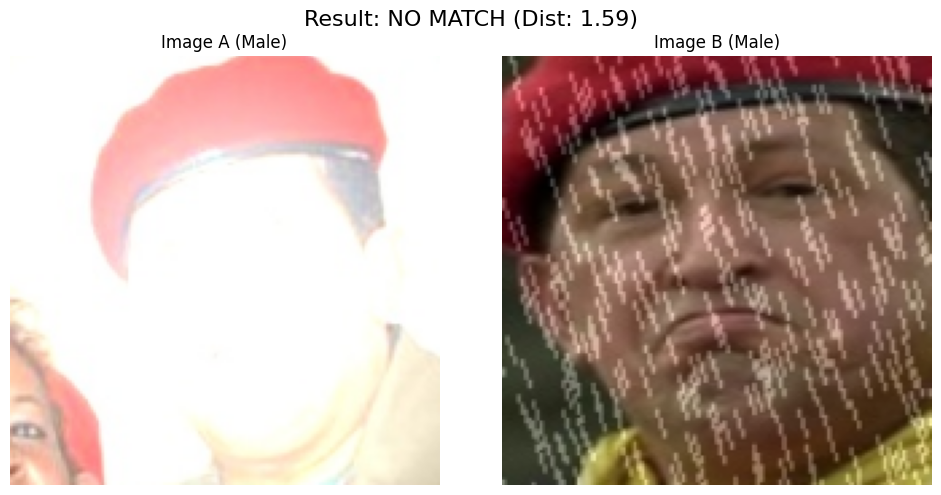


--- Comparing Laura_Marlow_0001_resized.jpg and Helio_Castroneves_0001_rainy.jpg ---
  - Calculated Distance: 1.4226
  - Decision Threshold:  1.1485
  A. SAME PERSON?      -> NO MATCH
  B. Image A Gender:     -> Female
  C. Image B Gender:     -> Male


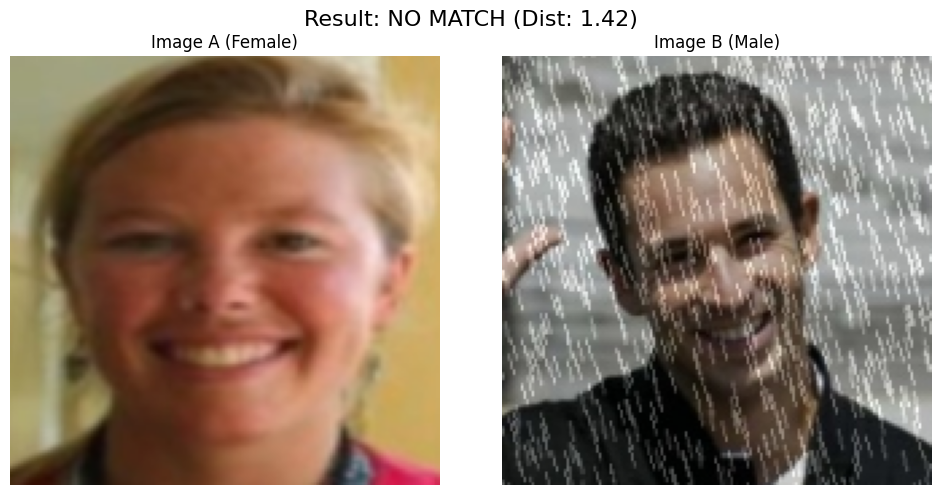

In [15]:
# --- 11. DEMONSTRATION---

def verify_and_classify(image_path1, image_path2, trained_model, threshold):
    """
    Loads two images, runs them through the model, and prints/visualizes the results.
    """
    print(f"\n--- Comparing {os.path.basename(image_path1)} and {os.path.basename(image_path2)} ---")
    
    img1 = preprocess_image(image_path1)
    img2 = preprocess_image(image_path2)
    
    if img1 is None or img2 is None:
        print("Could not find a face in one or both images.")
        return
        

    img1_batch = np.expand_dims(img1, axis=0)
    img2_batch = np.expand_dims(img2, axis=0)
    
    distance, gender1_pred, gender2_pred = trained_model.predict([img1_batch, img2_batch], verbose=0)
    

    distance_val = distance[0][0]
    is_match = distance_val < threshold
    gender1 = "Female" if gender1_pred[0][0] > 0.5 else "Male"
    gender2 = "Female" if gender2_pred[0][0] > 0.5 else "Male"
    
    print(f"  - Calculated Distance: {distance_val:.4f}")
    print(f"  - Decision Threshold:  {threshold:.4f}")
    print(f"  A. SAME PERSON?      -> {'MATCH!' if is_match else 'NO MATCH'}")
    print(f"  B. Image A Gender:     -> {gender1}")
    print(f"  C. Image B Gender:     -> {gender2}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img1)
    ax2.imshow(img2)
    
    ax1.set_title(f"Image A ({gender1})")
    ax2.set_title(f"Image B ({gender2})")
    fig.suptitle(f"Result: {'MATCH' if is_match else 'NO MATCH'} (Dist: {distance_val:.2f})", fontsize=16)

    ax1.axis('off')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()


print("\n--- Running Demonstration Cases ---")

# --- Test Case 1: Same Person (Positive Pair) ---
# Find a person in the validation set with at least two images
person_with_multiple_images = val_df['person_id'].value_counts()
person_to_test = person_with_multiple_images[person_with_multiple_images >= 2].index[0]

test_images_same = val_df[val_df['person_id'] == person_to_test].sample(2)
path1_same = test_images_same.iloc[0]['path']
path2_same = test_images_same.iloc[1]['path']
verify_and_classify(path1_same, path2_same, model, optimal_threshold)


# --- Test Case 2: Different People (Negative Pair) ---
person_id1, person_id2 = np.random.choice(val_df['person_id'].unique(), 2, replace=False)
path1_diff = val_df[val_df['person_id'] == person_id1].sample(1).iloc[0]['path']
path2_diff = val_df[val_df['person_id'] == person_id2].sample(1).iloc[0]['path']
verify_and_classify(path1_diff, path2_diff, model, optimal_threshold)

--- Running The Ultimate Comprehensive Evaluation on Validation Set ---
Created 5000 pairs for final evaluation.


Getting Gender A:   0%|          | 0/5000 [00:00<?, ?it/s]

Getting Gender B:   0%|          | 0/5000 [00:00<?, ?it/s]

Making Predictions:   0%|          | 0/157 [00:00<?, ?it/s]


                 FINAL MODEL EVALUATION RESULTS

--- Task B: Face Recognition Metrics ---
              precision    recall  f1-score   support

No Match (0)       0.73      0.95      0.83      2500
   Match (1)       0.93      0.65      0.76      2500

    accuracy                           0.80      5000
   macro avg       0.83      0.80      0.80      5000
weighted avg       0.83      0.80      0.80      5000

-----------------------------------------------------------------

--- Task A: Gender Classification Metrics ---

> Average Gender Accuracy (Heads A & B): 89.70%

-- Detailed Report for Head A --
              precision    recall  f1-score   support

        Male       0.95      0.93      0.94      3968
      Female       0.74      0.80      0.77      1032

    accuracy                           0.90      5000
   macro avg       0.84      0.86      0.85      5000
weighted avg       0.90      0.90      0.90      5000

-- Detailed Report for Head B --
              precision   

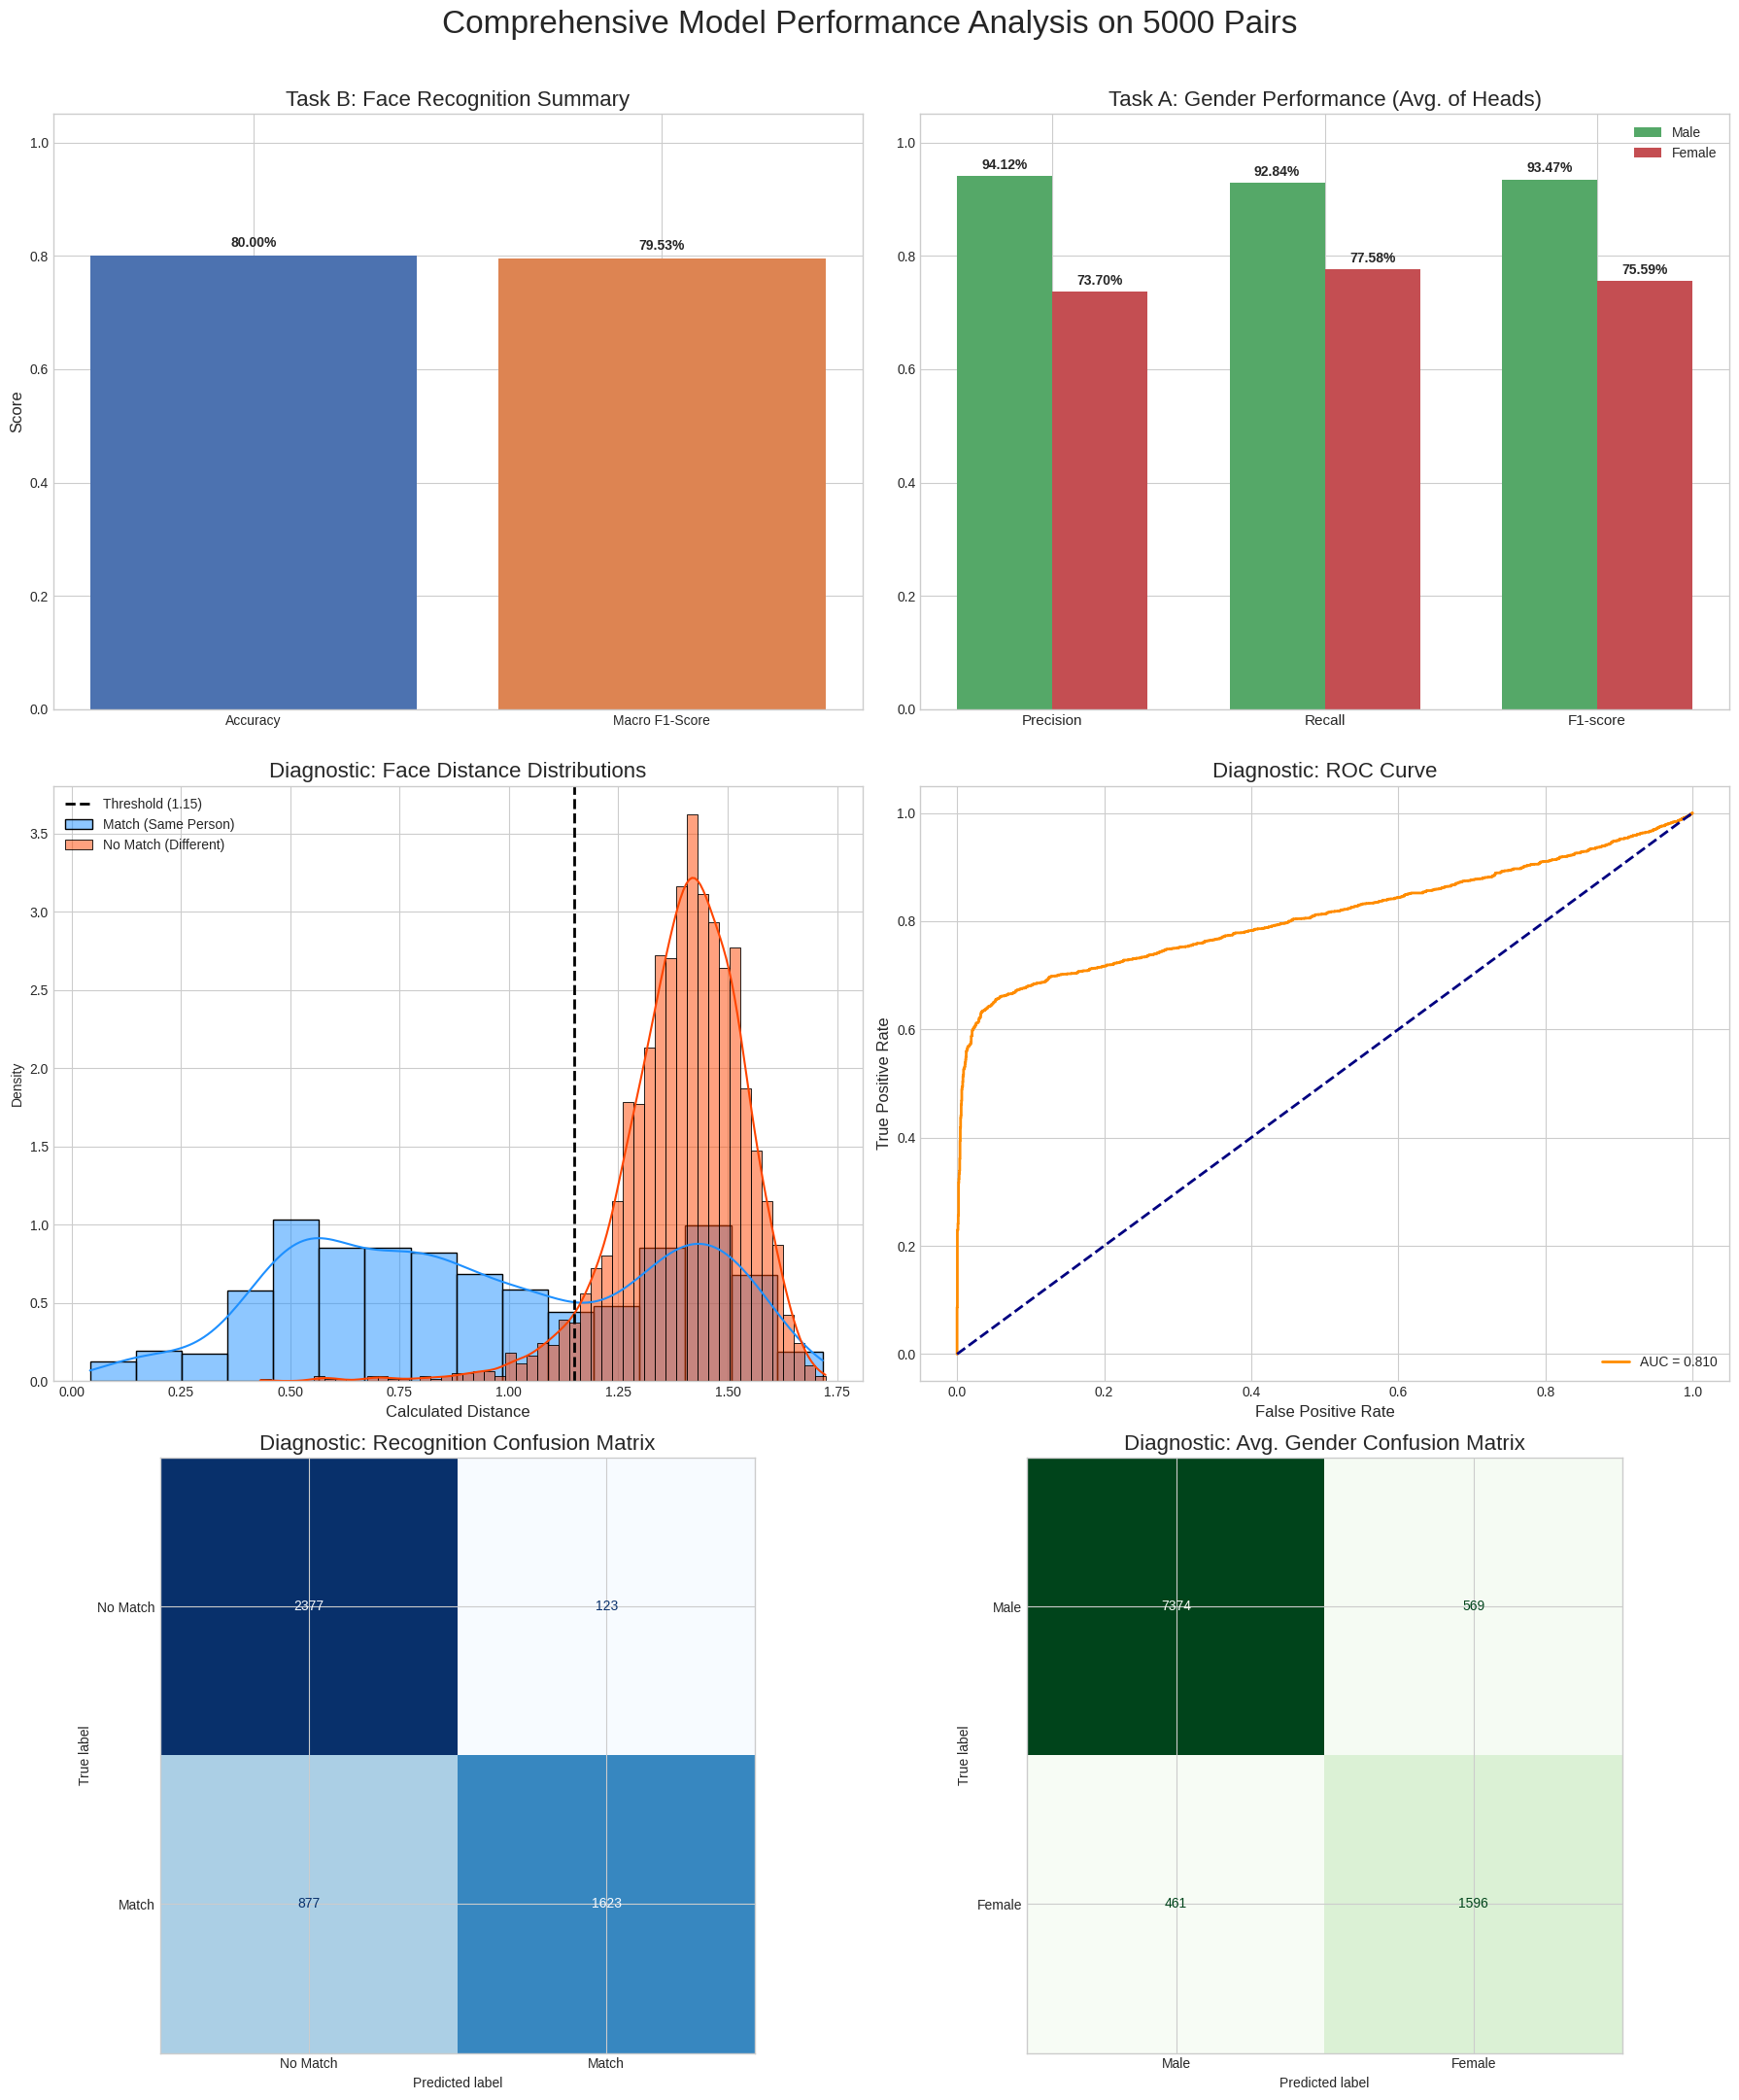

In [16]:
# --- 12. EVALUATION & VISUALIZATION DASHBOARD ---
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay, 
                             roc_curve, auc)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

# Suppress the harmless FutureWarning from seaborn for a cleaner output
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

print("--- Running The Ultimate Comprehensive Evaluation on Validation Set ---")

# 1. Create a fixed, large set of evaluation pairs
NUM_EVAL_PAIRS = 5000
eval_paths_a, eval_paths_b, y_true_dist_eval = create_evaluation_pairs(val_df, num_pairs=NUM_EVAL_PAIRS)
print(f"Created {len(y_true_dist_eval)} pairs for final evaluation.")

# 2. Get true gender labels for these pairs
def get_gender_from_path(df, path):
    gender = df.loc[df['cached_path'] == path, 'gender']
    return gender.iloc[0] if not gender.empty else -1

y_true_gender_a = np.array([get_gender_from_path(val_df, p) for p in tqdm(eval_paths_a, desc="Getting Gender A")])
y_true_gender_b = np.array([get_gender_from_path(val_df, p) for p in tqdm(eval_paths_b, desc="Getting Gender B")])

# 3. Make predictions in batches
y_pred_dist_eval, y_pred_gender_a_prob, y_pred_gender_b_prob = [], [], []
for i in tqdm(range(0, len(eval_paths_a), BATCH_SIZE), desc="Making Predictions"):
    batch_a_paths, batch_b_paths = eval_paths_a[i:i+BATCH_SIZE], eval_paths_b[i:i+BATCH_SIZE]
    batch_a_imgs = np.array([img for p in batch_a_paths if (img := load_cached_image(p)) is not None])
    batch_b_imgs = np.array([img for p in batch_b_paths if (img := load_cached_image(p)) is not None])
    if batch_a_imgs.shape[0] == 0 or batch_a_imgs.shape[0] != batch_b_imgs.shape[0]: continue
    dist_pred, gender1_pred, gender2_pred = model.predict([batch_a_imgs, batch_b_imgs], verbose=0)
    y_pred_dist_eval.extend(dist_pred.flatten())
    y_pred_gender_a_prob.extend(gender1_pred.flatten())
    y_pred_gender_b_prob.extend(gender2_pred.flatten())

# 4. Process predictions and ground truth
min_len = min(len(y_true_dist_eval), len(y_pred_dist_eval))
y_true_dist_eval, y_pred_dist_eval = np.array(y_true_dist_eval[:min_len]), np.array(y_pred_dist_eval[:min_len])
y_true_gender_a, y_pred_gender_a_prob = y_true_gender_a[:min_len], np.array(y_pred_gender_a_prob[:min_len])
y_true_gender_b, y_pred_gender_b_prob = y_true_gender_b[:min_len], np.array(y_pred_gender_b_prob[:min_len])

y_true_match = (y_true_dist_eval == 1.0).astype(int)
y_pred_match = (y_pred_dist_eval < optimal_threshold).astype(int)
y_pred_gender_a = (y_pred_gender_a_prob > 0.5).astype(int)
y_pred_gender_b = (y_pred_gender_b_prob > 0.5).astype(int)

# 5. Calculate Metrics & Generate Reports for Printing
# Task B
task_b_accuracy = accuracy_score(y_true_match, y_pred_match)
task_b_f1_macro = f1_score(y_true_match, y_pred_match, average='macro')
# Task A
report_a_dict = classification_report(y_true_gender_a, y_pred_gender_a, target_names=['Male', 'Female'], output_dict=True)
report_b_dict = classification_report(y_true_gender_b, y_pred_gender_b, target_names=['Male', 'Female'], output_dict=True)
avg_gender_acc = (report_a_dict['accuracy'] + report_b_dict['accuracy']) / 2

# 6. Print Formatted Text Report
print("\n" + "="*65)
print(" " * 17 + "FINAL MODEL EVALUATION RESULTS")
print("="*65)
print("\n--- Task B: Face Recognition Metrics ---")
print(classification_report(y_true_match, y_pred_match, target_names=['No Match (0)', 'Match (1)']))
print("-"*65)
print("\n--- Task A: Gender Classification Metrics ---")
print(f"\n> Average Gender Accuracy (Heads A & B): {avg_gender_acc:.2%}\n")
print("-- Detailed Report for Head A --")
print(classification_report(y_true_gender_a, y_pred_gender_a, target_names=['Male', 'Female']))
print("-- Detailed Report for Head B --")
print(classification_report(y_true_gender_b, y_pred_gender_b, target_names=['Male', 'Female']))
print("="*65)

# 7. Create the ULTIMATE Visualization Dashboard (3x2 Grid)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 2, figsize=(18, 22))
fig.suptitle(f'Comprehensive Model Performance Analysis on {len(y_true_match)} Pairs', fontsize=24)

# --- ROW 1: HIGH-LEVEL SUMMARIES ---

# Plot 1: Face Recognition Performance Summary
ax = axes[0, 0]
task_b_labels = ['Accuracy', 'Macro F1-Score']
task_b_values = [task_b_accuracy, task_b_f1_macro]
bars = ax.bar(task_b_labels, task_b_values, color=['#4C72B0', '#DD8452'])
ax.set_title('Task B: Face Recognition Summary', fontsize=16)
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0, 1.05)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom', weight='bold')

# Plot 2: Gender Classification Performance Summary
ax = axes[0, 1]
metrics = ['precision', 'recall', 'f1-score']
male_scores = [(report_a_dict['Male'][m] + report_b_dict['Male'][m]) / 2 for m in metrics]
female_scores = [(report_a_dict['Female'][m] + report_b_dict['Female'][m]) / 2 for m in metrics]
x = np.arange(len(metrics))
width = 0.35
rects1 = ax.bar(x - width/2, male_scores, width, label='Male', color='#55A868')
rects2 = ax.bar(x + width/2, female_scores, width, label='Female', color='#C44E52')
ax.set_title('Task A: Gender Performance (Avg. of Heads)', fontsize=16)
ax.set_ylim(0, 1.05)
ax.set_xticks(x, [m.capitalize() for m in metrics], fontsize=11)
ax.legend()
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2%}', xy=(rect.get_x() + rect.get_width()/2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', weight='bold')

# --- ROW 2: FACE RECOGNITION DIAGNOSTICS ---

# Plot 3: Distance Distribution Histogram
ax = axes[1, 0]
sns.histplot(y_pred_dist_eval[y_true_match == 1], color="dodgerblue", label='Match (Same Person)', ax=ax, stat='density', kde=True)
sns.histplot(y_pred_dist_eval[y_true_match == 0], color="orangered", label='No Match (Different)', ax=ax, stat='density', kde=True)
ax.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({optimal_threshold:.2f})')
ax.set_title('Diagnostic: Face Distance Distributions', fontsize=16)
ax.set_xlabel('Calculated Distance', fontsize=12)
ax.legend()

# Plot 4: ROC Curve for Face Recognition
ax = axes[1, 1]
fpr, tpr, _ = roc_curve(y_true_match, y_pred_dist_eval * -1)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_title('Diagnostic: ROC Curve', fontsize=16)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(loc="lower right")

# --- ROW 3: CONFUSION MATRICES ---

# Plot 5: Confusion Matrix for Face Recognition
ax = axes[2, 0]
cm_match = confusion_matrix(y_true_match, y_pred_match)
disp_match = ConfusionMatrixDisplay(confusion_matrix=cm_match, display_labels=['No Match', 'Match'])
disp_match.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Diagnostic: Recognition Confusion Matrix', fontsize=16)

# Plot 6: Confusion Matrix for Gender Classification (Averaged)
ax = axes[2, 1]
cm_gender_a = confusion_matrix(y_true_gender_a, y_pred_gender_a)
cm_gender_b = confusion_matrix(y_true_gender_b, y_pred_gender_b)
cm_gender_avg = (cm_gender_a + cm_gender_b) # Sum the counts for an overall view
disp_gender = ConfusionMatrixDisplay(confusion_matrix=cm_gender_avg.astype(int), display_labels=['Male', 'Female'])
disp_gender.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title('Diagnostic: Avg. Gender Confusion Matrix', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make room for suptitle
plt.show()

In [17]:
# --- 14. THE ULTIMATE INTERACTIVE TESTING DASHBOARD ---
import ipywidgets as widgets
from IPython.display import display, clear_output
import tempfile
import zipfile
import os
import shutil
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import io  # <-- FIX 1: IMPORT THE 'io' MODULE FOR IN-MEMORY FILE HANDLING

# Helper function to suppress seaborn's future warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

# --- PART 1: HELPER & VISUALIZATION FUNCTIONS ---

# This function might be needed for model loading if it was used during training
def scaling(x, scale=0.1):
    return x * scale

# The side-by-side visual comparison function
def display_single_prediction(image_path1, image_path2, trained_model, threshold):
    print(f"\n--- Comparing: {os.path.basename(image_path1)} vs {os.path.basename(image_path2)} ---")
    img1 = preprocess_image(image_path1) # Assumes preprocess_image is defined in a previous cell
    img2 = preprocess_image(image_path2)
    if img1 is None or img2 is None:
        print("-> Could not process one or both images.")
        return
    
    img1_batch, img2_batch = np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)
    distance, gender1_pred, gender2_pred = trained_model.predict([img1_batch, img2_batch], verbose=0)
    
    distance_val = distance[0][0]
    is_match = distance_val < threshold
    # The gender here is what the model *predicts*, not the ground truth
    gender1, gender2 = ("Female" if p > 0.5 else "Male" for p in [gender1_pred[0][0], gender2_pred[0][0]])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(img1); ax1.set_title(f"Image A (Predicted: {gender1})"); ax1.axis('off')
    ax2.imshow(img2); ax2.set_title(f"Image B (Predicted: {gender2})"); ax2.axis('off')
    result_text = f"Result: {'MATCH' if is_match else 'NO MATCH'} (Dist: {distance_val:.2f})"
    fig.suptitle(result_text, fontsize=16, color='green' if is_match else 'red')
    plt.show()

# The full dashboard plotting function, now robust to missing gender data
def generate_full_dashboard(y_true_match, y_pred_match, y_pred_dist_eval, optimal_threshold, y_true_gender_a=None, y_pred_gender_a=None, y_true_gender_b=None, y_pred_gender_b=None):
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, f1_score
    import seaborn as sns
    
    print("\n" + "="*65)
    print(" " * 17 + "DATASET EVALUATION DASHBOARD")
    print("="*65)
    
    # Check if we have gender ground truth to evaluate against
    has_gender_truth = y_true_gender_a is not None and y_true_gender_b is not None
    
    # Calculate metrics needed for plots
    task_b_accuracy = accuracy_score(y_true_match, y_pred_match)
    task_b_f1_macro = f1_score(y_true_match, y_pred_match, average='macro')

    fig, axes = plt.subplots(3, 2, figsize=(18, 22))
    fig.suptitle(f'Comprehensive Model Performance Analysis on {len(y_true_match)} Pairs', fontsize=24)
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot 1: Face Recognition Summary
    ax = axes[0, 0]
    bars = ax.bar(['Accuracy', 'Macro F1-Score'], [task_b_accuracy, task_b_f1_macro], color=['#4C72B0', '#DD8452'])
    ax.set_title('Task B: Face Recognition Summary', fontsize=16)
    ax.set_ylim(0, 1.05)
    for bar in bars:
        yval = bar.get_height(); ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2%}', ha='center', weight='bold')

    # Plot 2: Gender Performance Summary (Conditional)
    ax = axes[0, 1]
    ax.set_title('Task A: Gender Performance (Avg. of Heads)', fontsize=16)
    ax.set_ylim(0, 1.05)
    if has_gender_truth:
        report_a_dict = classification_report(y_true_gender_a, y_pred_gender_a, target_names=['Male', 'Female'], output_dict=True)
        report_b_dict = classification_report(y_true_gender_b, y_pred_gender_b, target_names=['Male', 'Female'], output_dict=True)
        metrics = ['precision', 'recall', 'f1-score']
        male_scores = [(report_a_dict['Male'][m] + report_b_dict['Male'][m]) / 2 for m in metrics]
        female_scores = [(report_a_dict['Female'][m] + report_b_dict['Female'][m]) / 2 for m in metrics]
        x, width = np.arange(len(metrics)), 0.35
        rects1 = ax.bar(x - width/2, male_scores, width, label='Male', color='#55A868')
        rects2 = ax.bar(x + width/2, female_scores, width, label='Female', color='#C44E52')
        ax.set_xticks(x, [m.capitalize() for m in metrics]); ax.legend()
        for rect in rects1 + rects2:
            height = rect.get_height(); ax.annotate(f'{height:.2%}', xy=(rect.get_x()+rect.get_width()/2, height), xytext=(0,3), textcoords="offset points", ha='center', weight='bold')
    else:
        ax.text(0.5, 0.5, "Gender ground truth not available\nfor this dataset.", ha='center', va='center', fontsize=14, style='italic', color='gray')
    
    # Plot 3: Distance Distribution
    ax = axes[1, 0]
    sns.histplot(y_pred_dist_eval[y_true_match == 1], color="dodgerblue", label='Match', ax=ax, stat='density', kde=True)
    sns.histplot(y_pred_dist_eval[y_true_match == 0], color="orangered", label='No Match', ax=ax, stat='density', kde=True)
    ax.axvline(optimal_threshold, color='black', linestyle='--', label=f'Threshold ({optimal_threshold:.2f})')
    ax.set_title('Diagnostic: Face Distance Distributions', fontsize=16); ax.legend()

    # Plot 4: ROC Curve
    ax = axes[1, 1]
    fpr, tpr, _ = roc_curve(y_true_match, y_pred_dist_eval * -1)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_title('Diagnostic: ROC Curve', fontsize=16); ax.legend(loc="lower right")

    # Plot 5: Recognition Confusion Matrix
    ax = axes[2, 0]
    ConfusionMatrixDisplay(confusion_matrix(y_true_match, y_pred_match), display_labels=['No Match', 'Match']).plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title('Diagnostic: Recognition Confusion Matrix', fontsize=16)

    # Plot 6: Gender Confusion Matrix (Conditional)
    ax = axes[2, 1]
    ax.set_title('Diagnostic: Avg. Gender Confusion Matrix', fontsize=16)
    if has_gender_truth:
        cm_gender_avg = (confusion_matrix(y_true_gender_a, y_pred_gender_a) + confusion_matrix(y_true_gender_b, y_pred_gender_b))
        ConfusionMatrixDisplay(cm_gender_avg.astype(int), display_labels=['Male', 'Female']).plot(ax=ax, cmap='Greens', colorbar=False)
    else:
        ax.text(0.5, 0.5, "Gender ground truth not available.", ha='center', va='center', fontsize=12, style='italic', color='gray')

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

# --- PART 2: UI WIDGETS DEFINITION ---

# Main controller
mode_switch = widgets.ToggleButtons(options=['Single Pair Test', 'Dataset Test'], description='Mode:')

# Model selection (shared across modes)
model_uploader = widgets.FileUpload(description="Upload Model", accept='.h5,.keras', layout=widgets.Layout(width='200px'))
model_path_input = widgets.Text(description="Or Model Path:", placeholder='e.g., /kaggle/working/face_verification_model.h5', layout=widgets.Layout(width='400px'))
model_box = widgets.VBox([widgets.HTML("<h4>Step 1: Choose Model (Optional)</h4>"), widgets.HBox([model_uploader, model_path_input])])

# --- UI for 'Single Pair' mode ---
uploader1 = widgets.FileUpload(description="Upload Image 1", accept='image/*')
uploader2 = widgets.FileUpload(description="Upload Image 2", accept='image/*')
path_input1 = widgets.Text(description="Or Path 1:", placeholder='Enter full path to image 1', layout=widgets.Layout(width='400px'))
path_input2 = widgets.Text(description="Or Path 2:", placeholder='Enter full path to image 2', layout=widgets.Layout(width='400px'))
single_pair_ui = widgets.VBox([
    widgets.HTML("<h4>Step 2: Provide Two Images</h4>"),
    widgets.HBox([uploader1, uploader2]),
    widgets.HBox([path_input1, path_input2])
])

# --- UI for 'Dataset' mode ---
dataset_uploader = widgets.FileUpload(description="Upload Dataset (.zip)", accept='.zip', layout=widgets.Layout(width='300px'))
num_pairs_input = widgets.IntText(value=1000, description='Pairs to Generate:', style={'description_width': 'initial'})
num_visuals_slider = widgets.IntSlider(value=5, min=0, max=50, step=1, description='Visual Samples:', style={'description_width': 'initial'})
dataset_ui = widgets.VBox([
    widgets.HTML("<h4>Step 2: Provide Dataset</h4>"),
    widgets.HTML("<b>Warning:</b> Upload a .zip file where all images are in the base directory (no subfolders)."),
    widgets.HBox([dataset_uploader, num_pairs_input, num_visuals_slider])
], layout={'display': 'none'}) # Hidden by default

# Main button and output area
process_button = widgets.Button(description="Verify Pair", button_style='success', icon='check')
output_area = widgets.Output()

# --- PART 3: DYNAMIC UI & CORE LOGIC ---

# Function to change UI based on mode switch
def on_mode_change(change):
    if change['new'] == 'Single Pair Test':
        single_pair_ui.layout.display = 'flex'
        dataset_ui.layout.display = 'none'
        process_button.description = "Verify Pair"
    else:
        single_pair_ui.layout.display = 'none'
        dataset_ui.layout.display = 'flex'
        process_button.description = "Process Dataset"
mode_switch.observe(on_mode_change, names='value')

# Function to parse filenames to extract person IDs
def parse_person_id_from_filename(filename):
    try:
        base_name = os.path.splitext(filename)[0]
        person_id = base_name.split('_')[0].split('-')[0]
        return person_id if person_id else None
    except:
        return None

# The main function that runs on button click
def on_process_button_clicked(b):
    with output_area:
        clear_output(wait=True)
        
        # --- 1. Load the Model ---
        try:
            # Assumes these custom objects are defined in the notebook's scope
            custom_objects={'contrastive_loss': contrastive_loss, 'weighted_bce': weighted_bce_loss_fn, 'scaling': scaling}
            if model_uploader.value:
                input_model_file = model_uploader.value[0]
                with tempfile.NamedTemporaryFile(suffix=".h5", delete=False) as temp_f:
                    temp_f.write(input_model_file['content']); temp_model_path = temp_f.name
                inference_model = load_model(temp_model_path, custom_objects=custom_objects)
                os.remove(temp_model_path)
            elif model_path_input.value:
                if not os.path.exists(model_path_input.value): print(f"Model path not found: {model_path_input.value}"); return
                inference_model = load_model(model_path_input.value, custom_objects=custom_objects)
            else:
                inference_model = model # Use the model trained in this session
            print("Model loaded successfully.")
        except Exception as e: print(f"Error loading model: {e}"); return
        
        # --- 2. Execute based on selected mode ---
        if mode_switch.value == 'Single Pair Test':
            # --- Single Pair Logic ---
            temp_dir = tempfile.gettempdir()
            path1, path2 = None, None
            if path_input1.value: path1 = path_input1.value
            elif uploader1.value:
                # FIX: The correct key for the filename is 'name', not 'metadata.name'
                f = uploader1.value[0]; path1 = os.path.join(temp_dir, f['name']); open(path1, 'wb').write(f['content'])
            if path_input2.value: path2 = path_input2.value
            elif uploader2.value:
                # FIX: The correct key for the filename is 'name', not 'metadata.name'
                f = uploader2.value[0]; path2 = os.path.join(temp_dir, f['name']); open(path2, 'wb').write(f['content'])
            if path1 and path2:
                display_single_prediction(path1, path2, inference_model, optimal_threshold)
            else:
                print("Error: Please provide two images for comparison.")
        else:
            # --- Dataset Logic ---
            if not dataset_uploader.value:
                print("Error: Please upload a .zip dataset file."); return
            
            zip_file_info = dataset_uploader.value[0]
            extract_path = os.path.join(tempfile.gettempdir(), 'extracted_dataset')
            if os.path.exists(extract_path): shutil.rmtree(extract_path)
            os.makedirs(extract_path)
            
            try:
                # Use io.BytesIO to handle the in-memory file data
                with zipfile.ZipFile(io.BytesIO(zip_file_info['content']), 'r') as z:
                    z.extractall(extract_path)
            except Exception as e:
                print(f"Error unzipping file: {e}. Please ensure it is a valid .zip file."); return
            print(f"Dataset extracted to temporary directory.")
            
            image_records = [{'path': os.path.join(extract_path, fname), 'person_id': person_id} for fname in os.listdir(extract_path) if fname.lower().endswith(('.jpg', '.png', '.jpeg')) and (person_id := parse_person_id_from_filename(fname))]
            if not image_records:
                print("\n\033[91mCRITICAL WARNING: No images with parsable names found!\033[0m"); return

            dataset_df = pd.DataFrame(image_records)
            paths_a, paths_b, y_true_match = create_evaluation_pairs(dataset_df, num_pairs=num_pairs_input.value)
            print(f"\nGenerated {len(y_true_match)} pairs for evaluation.")
            
            y_pred_dist = []
            for i in tqdm(range(0, len(paths_a), BATCH_SIZE), desc="Batch Predicting"):
                batch_a = np.array([img for p in paths_a[i:i+BATCH_SIZE] if (img := preprocess_image(p)) is not None])
                batch_b = np.array([img for p in paths_b[i:i+BATCH_SIZE] if (img := preprocess_image(p)) is not None])
                if batch_a.shape[0] == 0: continue
                dist, _, _ = inference_model.predict([batch_a, batch_b], verbose=0)
                y_pred_dist.extend(dist.flatten())
            
            num_to_show = min(num_visuals_slider.value, len(paths_a))
            if num_to_show > 0:
                print(f"\n--- Displaying {num_to_show} Visual Samples ---")
                for i in range(num_to_show):
                    display_single_prediction(paths_a[i], paths_b[i], inference_model, optimal_threshold)

            # Call dashboard WITHOUT fake gender labels.
            generate_full_dashboard(np.array(y_true_match), (np.array(y_pred_dist) < optimal_threshold).astype(int), 
                                    np.array(y_pred_dist), optimal_threshold)
            
process_button.on_click(on_process_button_clicked)

# --- PART 4: ASSEMBLE AND DISPLAY THE FINAL UI ---
final_ui = widgets.VBox([
    widgets.HTML("<h2>Ultimate Testing Dashboard</h2>"),
    mode_switch,
    widgets.HTML("<hr>"),
    model_box,
    widgets.HTML("<hr>"),
    single_pair_ui,
    dataset_ui,
    widgets.HTML("<hr>"),
    process_button,
    output_area
])
display(final_ui)